In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops
from waymo_open_dataset import dataset_pb2 as open_dataset

In [46]:
import os
os.environ['CURL_CA_BUNDLE'] = '/home/aaylen/Documents/Waymo-Challenge/cacert.pem'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/aaylen/Documents/Waymo-Challenge/token.json'

In [47]:

# Dataset paths
DATASET_FOLDER = 'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0'
TRAIN_FILES = os.path.join(DATASET_FOLDER, '*.tfrecord-*')

# Load dataset
def load_dataset(file_pattern, num_files=2):
    filenames = tf.io.matching_files(file_pattern)
    filenames = filenames[:num_files]
    dataset = tf.data.TFRecordDataset(filenames, compression_type='')
    return dataset

# Parse frame (adapted from tutorial's return_front3_cameras)
def parse_frame(bytes_data):
    frame = wod_e2ed_pb2.E2EDFrame()
    frame.ParseFromString(bytes_data.numpy())
    
    # Extract trajectory
    trajectory = np.stack([frame.future_states.pos_x[:20], 
                          frame.future_states.pos_y[:20], 
                          frame.future_states.pos_z[:20]], axis=1)
    trajectory = tf.convert_to_tensor(trajectory, dtype=tf.float32)
    
    # Camera names: 1 (front), 2 (front_left), 3 (front_right)
    order = [2, 1, 3]  # front_left, front, front_right
    image_list = []
    calibration_list = []
    original_images = []
    
    for camera_name in order:
        for index, image_content in enumerate(frame.frame.images):
            if image_content.name == camera_name:
                calibration = frame.frame.context.camera_calibrations[index]
                image = tf.io.decode_image(image_content.image)
                original_images.append(image.numpy())
                resized_img = tf.image.resize(image, [224, 224])
                image_list.append(tf.cast(resized_img, tf.float32) / 255.0)
                calibration_list.append(calibration)
                break
        else:
            # If camera not found, append placeholders
            image_list.append(tf.zeros([224, 224, 3], dtype=tf.float32))
            original_images.append(np.zeros([480, 640, 3], dtype=np.uint8))  # Adjust size if needed
            calibration_list.append(None)
    
    return image_list, trajectory, original_images, calibration_list

In [48]:
# Wrapper function
def parse_frame_wrapper(bytes_data):
    images, trajectory, original_images, calibrations = tf.py_function(
        parse_frame, [bytes_data], 
        [tf.float32, tf.float32, tf.uint8, object])
    
    # Set shapes for tensors
    for img in images:
        img.set_shape([224, 224, 3])
    trajectory.set_shape([20, 3])
    for orig_img in original_images:
        orig_img.set_shape([480, 640, 3])  # Adjust based on actual size
    
    return images, trajectory, original_images, calibrations

In [49]:
# Dataset preparation
dataset = load_dataset(TRAIN_FILES, num_files=2)
dataset = dataset.map(parse_frame_wrapper)
dataset = dataset.filter(lambda imgs, traj, orig_imgs, calibs: tf.reduce_all(tf.not_equal(imgs[1], 0)))  # Check front camera
dataset = dataset.shuffle(1000)
dataset = dataset.take(800).cache()

dataset_size = 800
train_size = int(0.8 * dataset_size)

# Training dataset (front camera only)
train_dataset = dataset.take(train_size).map(lambda imgs, traj, orig_imgs, calibs: (imgs[1], traj[:, :2])).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).map(lambda imgs, traj, orig_imgs, calibs: (imgs[1], traj[:, :2])).batch(32).prefetch(tf.data.AUTOTUNE)

# Visualization dataset
vis_val_dataset = dataset.skip(train_size)

In [50]:
print(f"Dataset size: {dataset_size}")

Dataset size: 800


In [51]:
# Build ResNet model
def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = True
    # Optionally, freeze early layers and fine-tune later ones
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(20 * 2),
        tf.keras.layers.Reshape((20, 2))
    ])
    return model

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mae'])

In [ ]:
# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4
)

Epoch 1/4


2025-04-08 23:54:50.565112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2025-04-08 23:54:50.565377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2025-04-08 23:54:59.108262: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: Attempt to convert a value (name: FRONT_LEFT
intrinsic: 1112.7611083984375
intrinsic: 1112.6240234375
intrinsic: 488.12847900390625
intrinsic: 719.156005859375
intrinsic: -0.073583997786045074
intrinsic: -0.036582

InvalidArgumentError: Graph execution error:

ValueError: Attempt to convert a value (name: FRONT_LEFT
intrinsic: 1112.7611083984375
intrinsic: 1112.6240234375
intrinsic: 488.12847900390625
intrinsic: 719.156005859375
intrinsic: -0.073583997786045074
intrinsic: -0.036582000553607941
intrinsic: 0
intrinsic: 0
intrinsic: 0
extrinsic {
  transform: 0.70659250020980835
  transform: -0.70761978626251221
  transform: -0.0011406120611354709
  transform: 1.445099949836731
  transform: 0.70760083198547363
  transform: 0.70655965805053711
  transform: 0.008632994256913662
  transform: 0.15270000696182251
  transform: -0.0053029675036668777
  transform: -0.0069071073085069656
  transform: 0.99996209144592285
  transform: 1.80649995803833
  transform: 0
  transform: 0
  transform: 0
  transform: 1
}
width: 972
height: 1079
rolling_shutter_direction: LEFT_TO_RIGHT
) with an unsupported type (<class 'waymo_open_dataset.dataset_pb2.CameraCalibration'>) to a Tensor.
Traceback (most recent call last):

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 159, in _call
    outputs = [

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 160, in <listcomp>
    _maybe_copy_to_context_device(self._convert(x, dtype=dtype),

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 127, in _convert
    return ops.convert_to_tensor(value, dtype=dtype)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
    return func(*args, **kwargs)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 1642, in convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py", line 344, in _constant_tensor_conversion_function
    return constant(v, dtype=dtype, name=name)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py", line 268, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py", line 280, in _constant_impl
    return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py", line 305, in _constant_eager_impl
    t = convert_to_eager_tensor(value, ctx, dtype)

  File "/home/aaylen/.pyenv/versions/my_env/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py", line 103, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)

ValueError: Attempt to convert a value (name: FRONT_LEFT
intrinsic: 1112.7611083984375
intrinsic: 1112.6240234375
intrinsic: 488.12847900390625
intrinsic: 719.156005859375
intrinsic: -0.073583997786045074
intrinsic: -0.036582000553607941
intrinsic: 0
intrinsic: 0
intrinsic: 0
extrinsic {
  transform: 0.70659250020980835
  transform: -0.70761978626251221
  transform: -0.0011406120611354709
  transform: 1.445099949836731
  transform: 0.70760083198547363
  transform: 0.70655965805053711
  transform: 0.008632994256913662
  transform: 0.15270000696182251
  transform: -0.0053029675036668777
  transform: -0.0069071073085069656
  transform: 0.99996209144592285
  transform: 1.80649995803833
  transform: 0
  transform: 0
  transform: 0
  transform: 1
}
width: 972
height: 1079
rolling_shutter_direction: LEFT_TO_RIGHT
) with an unsupported type (<class 'waymo_open_dataset.dataset_pb2.CameraCalibration'>) to a Tensor.


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_230098]

2025-04-08 23:56:14.576373: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: Attempt to convert a value (name: FRONT_LEFT
intrinsic: 1115.4183349609375
intrinsic: 1115.281005859375
intrinsic: 488.12847900390625
intrinsic: 719.156005859375
intrinsic: -0.073583997786045074
intrinsic: -0.036582000553607941
intrinsic: 0
intrinsic: 0
intrinsic: 0
extrinsic {
  transform: 0.70653772354125977
  transform: -0.70767062902450562
  transform: 0.0025996018666774035
  transform: 1.445099949836731
  transform: 0.7075996994972229
  transform: 0.70651113986968994
  transform: 0.012030089274048805
  transform: 0.15270000696182251
  transform: -0.010349988006055355
  transform: -0.0066602341830730438
  transform: 0.99992424249649048
  transform: 1.80649995803833
  transform: 0
  transform: 0
  transform: 0
  transform: 1
}
width: 972
height: 1079
rolling_shutter_direction: LEFT_TO_RIGHT
) with an unsupported type (<class 'waymo_open_dataset.dataset_pb2.CameraCalibration'>) to

2025-04-08 23:56:16.864339: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: Attempt to convert a value (name: FRONT_LEFT
intrinsic: 1112.136962890625
intrinsic: 1112
intrinsic: 488.12847900390625
intrinsic: 719.156005859375
intrinsic: -0.073583997786045074
intrinsic: -0.036582000553607941
intrinsic: 0
intrinsic: 0
intrinsic: 0
extrinsic {
  transform: 0.70526772737503052
  transform: -0.70889723300933838
  transform: -0.007878938689827919
  transform: 1.445099949836731
  transform: 0.70894092321395874
  transform: 0.70521742105484009
  transform: 0.0084356833249330521
  transform: 0.15270000696182251
  transform: -0.00042366841807961464
  transform: -0.011535117402672768
  transform: 0.99993336200714111
  transform: 1.80649995803833
  transform: 0
  transform: 0
  transform: 0
  transform: 1
}
width: 972
height: 1079
rolling_shutter_direction: LEFT_TO_RIGHT
) with an unsupported type (<class 'waymo_open_dataset.dataset_pb2.CameraCalibration'>) to a Tensor.


In [24]:
# ADE calculation
def compute_ade(predictions, ground_truth):
    dist_per_step = np.linalg.norm(predictions - ground_truth, axis=-1)
    return np.mean(dist_per_step)

In [ ]:
# Projection function (from tutorial)
def project_vehicle_to_image(vehicle_pose, calibration, points):
    if calibration is None:
        return np.zeros((points.shape[0], 3))  # Return dummy points if no calibration
    
    pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
    world_points = np.zeros_like(points)
    for i, point in enumerate(points):
        cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
        world_points[i] = (cx, cy, cz)

    extrinsic = tf.reshape(tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32), [4, 4])
    intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
    metadata = tf.constant([
        calibration.width,
        calibration.height,
        open_dataset.CameraCalibration.GLOBAL_SHUTTER,
    ], dtype=tf.int32)
    camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

    return py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata,
                                              camera_image_metadata, world_points).numpy()

In [25]:
# Smoothing function
def smooth_trajectory(traj, window=3):
    smoothed = np.copy(traj)
    for i in range(1, len(traj) - 1):
        smoothed[i] = np.mean(traj[max(0, i-window//2):i+window//2+1], axis=0)
    return smoothed

In [ ]:
# Visualization function (adapted from tutorial)
def visualize_predictions(model, dataset, num_samples=3, dataset_name="Validation"):
    vis_dataset = dataset
    
    for i, (images, true_traj, original_images, calibrations) in enumerate(vis_dataset.take(num_samples)):
        print(f"Plotting {dataset_name} Sample {i+1}")
        
        # Predict using front camera (index 1)
        pred = model.predict(tf.expand_dims(images[1], 0), verbose=0)
        pred_traj = smooth_trajectory(pred[0])
        true_traj_full = true_traj.numpy() if isinstance(true_traj, tf.Tensor) else true_traj
        
        # Calculate ADE
        ade = compute_ade(pred_traj, true_traj_full[:, :2])
        
        # Prepare 3D trajectories
        pred_traj_3d = np.concatenate([pred_traj, true_traj_full[:, 2:3]], axis=1)
        
        # Project trajectories (assuming vehicle pose from front camera)
        vehicle_pose = wod_e2ed_pb2.CameraImage().pose  # Default identity pose
        images_with_points = []
        for j, (img, calib) in enumerate(zip(original_images, calibrations)):
            true_points = project_vehicle_to_image(vehicle_pose, calib, true_traj_full)
            pred_points = project_vehicle_to_image(vehicle_pose, calib, pred_traj_3d)
            
            # Draw points on image
            img_copy = img.copy()
            for point in true_points:
                cv2.circle(img_copy, (int(point[0]), int(point[1])), 5, (255, 0, 0), -1)  # Blue for ground truth
            for point in pred_points:
                cv2.circle(img_copy, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)  # Red for prediction
            images_with_points.append(img_copy)
        
        # Concatenate and display
        concatenated_image = np.concatenate(images_with_points, axis=1)
        plt.figure(figsize=(20, 7))
        plt.imshow(concatenated_image)
        plt.title(f'{dataset_name} Sample {i+1} - ADE: {ade:.2f} meters')
        plt.axis('off')
        plt.show()

Plotting Validation Sample 1 (Frame 641)


2025-04-08 23:34:53.763659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2025-04-08 23:34:53.763870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]


AttributeError: EagerTensor object has no attribute 'T'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

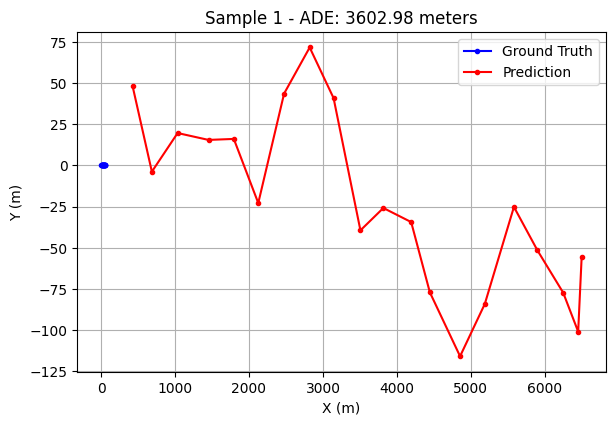

In [ ]:
# Visualize on validation set
visualize_predictions(model, vis_val_dataset, num_samples=3, dataset_name="Validation")

# Print metrics
print("Training history:")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final validation MAE: {history.history['val_mae'][-1]:.4f}")